In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
data = pd.read_csv(r"..\data\part_2\daily_data_cleaned.csv")
data.head()

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,condition_text
0,D0003,0,20.0,3.6,10,1011.0,4.5,100,75,20.0,10.0,1.0,12.6,1,3
1,D0004,0,17.0,6.1,150,1018.0,0.0,88,0,17.0,10.0,1.0,11.2,1,0
2,D0007,0,21.0,4.0,310,1015.0,0.0,100,50,21.0,10.0,1.0,15.1,2,6
3,D0019,0,19.0,3.6,64,1017.0,0.0,88,0,19.0,10.0,1.0,8.3,3,0
4,D0028,1,19.0,3.6,83,1010.0,0.0,73,25,19.0,10.0,1.0,8.3,1,6


In [3]:
le = LabelEncoder().fit(pickle.load(open(r"..\models\label_encoder.pkl", "rb")))

In [4]:
data

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,condition_text
0,D0003,0,20.0,3.6,10,1011.0,4.50,100,75,20.0,10.0,1.0,12.6,1,3
1,D0004,0,17.0,6.1,150,1018.0,0.00,88,0,17.0,10.0,1.0,11.2,1,0
2,D0007,0,21.0,4.0,310,1015.0,0.00,100,50,21.0,10.0,1.0,15.1,2,6
3,D0019,0,19.0,3.6,64,1017.0,0.00,88,0,19.0,10.0,1.0,8.3,3,0
4,D0028,1,19.0,3.6,83,1010.0,0.00,73,25,19.0,10.0,1.0,8.3,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,D2839,109,27.0,19.1,90,1014.0,0.01,70,25,29.8,10.0,6.0,45.6,1,6
475,D2864,110,21.4,3.6,178,1012.0,0.00,89,75,21.4,10.0,6.0,6.6,1,2
476,D2874,111,16.9,16.6,68,1018.0,0.00,44,2,16.9,10.0,1.0,27.0,1,0
477,D2887,111,19.5,5.4,27,1014.0,0.00,34,0,19.4,10.0,1.0,11.2,2,0


In [5]:
# Splitting the data into X and y
X = data.drop(columns=["day_id", "condition_text"])
y = data["condition_text"]

In [6]:
# Balancing the data
smote = SMOTE()

X, y = smote.fit_resample(X, y)

In [7]:
y.value_counts()

condition_text
3    122
0    122
6    122
2    122
1    122
4    122
7    122
5    122
8    122
Name: count, dtype: int64

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Initialize the random forest classifier
rf = RandomForestClassifier()

# Define the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, 25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
grid_search.best_params_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


{'bootstrap': False,
 'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [10]:
# Initialize the random forest classifier with the best parameters
rf = RandomForestClassifier(**grid_search.best_params_, random_state=42)

# Fit the random forest classifier
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=30, random_state=42)

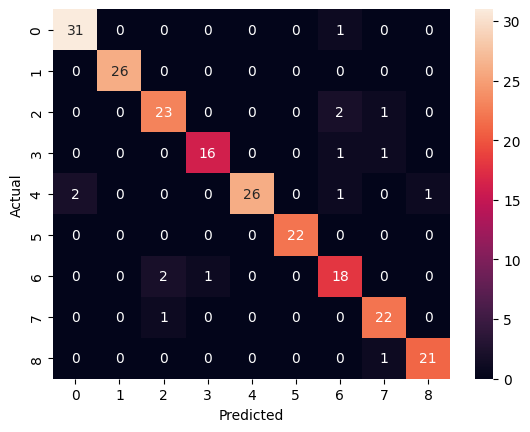

In [11]:
# Predict the test data
y_pred = rf.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix

# visulize the confusion matrix using seaborn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [12]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       1.00      1.00      1.00        26
           2       0.88      0.88      0.88        26
           3       0.94      0.89      0.91        18
           4       1.00      0.87      0.93        30
           5       1.00      1.00      1.00        22
           6       0.78      0.86      0.82        21
           7       0.88      0.96      0.92        23
           8       0.95      0.95      0.95        22

    accuracy                           0.93       220
   macro avg       0.93      0.93      0.93       220
weighted avg       0.93      0.93      0.93       220



In [13]:
# Get the predictions
predictions = pd.read_csv(r"..\data\part_2\predict_data.csv")

In [14]:
predictions

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index
0,D0001,0,27.0,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2
1,D0002,0,22.0,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1
2,D0005,0,18.0,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1
3,D0006,0,20.0,3.6,96,1019.0,0.0,88,0,20.0,10.0,1.0,11.2,1
4,D0008,0,21.0,20.2,330,1011.0,0.0,53,75,21.0,10.0,1.0,17.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,D2888,111,19.5,16.6,113,1015.0,0.0,38,0,19.5,10.0,1.0,26.7,1
2410,D2890,111,17.4,13.0,51,1017.0,0.0,49,0,17.4,10.0,1.0,22.2,1
2411,D2891,111,19.2,11.5,46,1016.0,0.0,34,0,19.2,10.0,1.0,21.3,2
2412,D2892,111,19.2,14.4,76,1017.0,0.0,45,2,19.2,10.0,1.0,24.9,2


In [15]:
X_pred = predictions.drop(columns=["day_id"])

In [17]:
# Predict the data
y_pred = rf.predict(X_pred)

# Inverse transform the predictions
y_pred = le.inverse_transform(y_pred)

# Add the predictions to the dataframe
predictions["condition_text"] = y_pred

predictions

,day_id,city_id,temperature_celsius,wind_kph,wind_degree,pressure_mb,precip_mm,humidity,cloud,feels_like_celsius,visibility_km,uv_index,gust_kph,air_quality_us-epa-index,condition_text
0,D0001,0,27.0,6.1,210,1006.0,0.0,54,75,28.0,10.0,6.0,11.9,2,Partly Cloudy
1,D0002,0,22.0,6.1,170,1006.0,0.0,73,75,24.5,10.0,1.0,23.4,1,Partly Cloudy
2,D0005,0,18.0,3.6,92,1019.0,0.0,94,0,18.0,10.0,1.0,9.0,1,Clear and Sunny
3,D0006,0,20.0,3.6,96,1019.0,0.0,88,0,20.0,10.0,1.0,11.2,1,Clear and Sunny
4,D0008,0,21.0,20.2,330,1011.0,0.0,53,75,21.0,10.0,1.0,17.3,1,Partly Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2409,D2888,111,19.5,16.6,113,1015.0,0.0,38,0,19.5,10.0,1.0,26.7,1,Clear and Sunny
2410,D2890,111,17.4,13.0,51,1017.0,0.0,49,0,17.4,10.0,1.0,22.2,1,Clear and Sunny
2411,D2891,111,19.2,11.5,46,1016.0,0.0,34,0,19.2,10.0,1.0,21.3,2,Clear and Sunny
2412,D2892,111,19.2,14.4,76,1017.0,0.0,45,2,19.2,10.0,1.0,24.9,2,Clear and Sunny


In [34]:
predictions[["day_id", "condition_text"]]

,day_id,condition_text
0,D0001,Partly Cloudy
1,D0002,Partly Cloudy
2,D0005,Clear and Sunny
3,D0006,Clear and Sunny
4,D0008,Partly Cloudy
...,...,...
2409,D2888,Clear and Sunny
2410,D2890,Clear and Sunny
2411,D2891,Clear and Sunny
2412,D2892,Clear and Sunny


In [35]:
submission = pd.read_csv(r"..\data\part_2\submission.csv")
submission

,day_id,condition_text
0,D0001,NaN
1,D0002,NaN
2,D0003,Light Rain with Thunder
3,D0004,Clear and Sunny
4,D0005,NaN
...,...,...
2888,D2889,Clear and Sunny
2889,D2890,NaN
2890,D2891,NaN
2891,D2892,NaN


In [36]:
# Left join the submission and predictions dataframes in one column
submission = submission.merge(predictions[["day_id", "condition_text"]], on="day_id", how="left")

In [37]:
# condition_text_y and condition_text_x fill with the values of condition_text_y
submission["condition_text"] = submission["condition_text_x"].fillna(submission["condition_text_y"])
submission

,day_id,condition_text_x,condition_text_y,condition_text
0,D0001,NaN,Partly Cloudy,Partly Cloudy
1,D0002,NaN,Partly Cloudy,Partly Cloudy
2,D0003,Light Rain with Thunder,NaN,Light Rain with Thunder
3,D0004,Clear and Sunny,NaN,Clear and Sunny
4,D0005,NaN,Clear and Sunny,Clear and Sunny
...,...,...,...,...
2888,D2889,Clear and Sunny,NaN,Clear and Sunny
2889,D2890,NaN,Clear and Sunny,Clear and Sunny
2890,D2891,NaN,Clear and Sunny,Clear and Sunny
2891,D2892,NaN,Clear and Sunny,Clear and Sunny


In [38]:
submission.drop(columns=["condition_text_x", "condition_text_y"], inplace=True)
submission

,day_id,condition_text
0,D0001,Partly Cloudy
1,D0002,Partly Cloudy
2,D0003,Light Rain with Thunder
3,D0004,Clear and Sunny
4,D0005,Clear and Sunny
...,...,...
2888,D2889,Clear and Sunny
2889,D2890,Clear and Sunny
2890,D2891,Clear and Sunny
2891,D2892,Clear and Sunny


In [39]:
submission.to_csv(r"..\data\part_2\submission_rf.csv", index=False)